### Model Training

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset

from tqdm import tqdm
import os
import opensmile
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from IPython.lib.display import Audio


Read data from processed CSV

In [2]:
# Read the data from data_classes_reduced.csv
data = pd.read_csv('/Users/pradyumn/Downloads/librosa_opensmile_data.csv')
data = data[data['emotion'].isin(['neu', 'ang', 'sad', 'hap'])]

# Define the features and labels
features_df_train = data.drop(['emotion', 'id'], axis=1)
labels = data['emotion']

Split Dataset into test and train with a 80 20 split

In [3]:
X_train, X_test, y_train, y_test = train_test_split(features_df_train, labels, test_size=0.2, random_state=42)
texts_train = X_train['recognized_text'].apply(lambda x: eval(x)['text']).to_list()
texts_test = X_test['recognized_text'].apply(lambda x: eval(x)['text']).to_list()

# Drop the recognized_text column as X_train and X_test are only used for audio features
X_train.drop('recognized_text', axis=1, inplace=True)
X_test.drop('recognized_text', axis=1, inplace=True)

In [4]:
# Helper function to scale the data
def preprocess_dataset(df_train, df_test):

    standard_scaler = preprocessing.StandardScaler()
    df_train_scaled = standard_scaler.fit_transform(df_train)
    df_test_scaled = standard_scaler.transform(df_test)

    return df_train_scaled, df_test_scaled

In [5]:
X_train_scaled, X_test_scaled = preprocess_dataset(X_train, X_test)
print(X_train_scaled.shape, X_test_scaled.shape)

(3920, 6556) (981, 6556)


Using a LabelEncoder convert the classes to integers for model training

In [6]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

Tokenize and pad the text data

In [7]:
# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts_train+texts_test)
sequences_train = tokenizer.texts_to_sequences(texts_train)
max_length_train = max([len(seq) for seq in sequences_train])
padded_sequences = pad_sequences(sequences_train, maxlen=max_length_train)

sequences_test = tokenizer.texts_to_sequences(texts_test)
max_length_test = max([len(seq) for seq in sequences_test])
padded_sequences_test = pad_sequences(sequences_test, maxlen=max_length_test)

In [8]:
# Create a custom dataset class to store the audio features, labels and text data
class CustomDataset(Dataset):
    def __init__(self, data, labels, text):
        self.data = data
        self.labels = labels
        self.text = text
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx], self.text[idx]

# Define the dataloaders to load the data in batches
def intialise_loaders(X_train, y_train, X_test, y_test, batch_size):
    train_data = CustomDataset(X_train, y_train, padded_sequences)
    test_data = CustomDataset(X_test, y_test, padded_sequences_test)
    train_dataloader = DataLoader(train_data, batch_size, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size, shuffle=True)
    return train_dataloader, test_dataloader

optimal_bs = 128
train_dataloader, test_dataloader = intialise_loaders(X_train_scaled, y_train_encoded, X_test_scaled, y_test_encoded, optimal_bs)

In [9]:
# Early stopping
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0, path='checkpoint.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0
        elif score > self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model to {self.path}')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [10]:
# Define the MLP model
class MLP(nn.Module):

    def __init__(self, no_features, no_hidden, no_labels):
        super().__init__()
        layers = []
        parameters = [no_features] + no_hidden
        for i in range(len(parameters) - 1):
            layers.append(nn.Linear(parameters[i], parameters[i+1]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.2))
        
        self.mlp_stack = nn.Sequential(*layers)
        self.fc = nn.Linear(parameters[-1], no_labels)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x1 = self.mlp_stack(x)
        u = self.fc(x1)
        y = self.softmax(u)
        return y
    
# Define the CNN model for NLP processing
class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_filters, filter_sizes, output_dim, dropout):
        super(CNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.convs = nn.ModuleList([
            nn.Conv2d(in_channels=1, out_channels=num_filters, kernel_size=(fs, embedding_dim))
            for fs in filter_sizes
        ])   
        self.fc = nn.Linear(len(filter_sizes) * num_filters, output_dim)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        x = x.unsqueeze(1)  
        embedded = self.embedding(x)  
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]  
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]  
        cat = self.dropout(torch.cat(pooled, dim=1))  
        output = self.fc(cat)  
        return output
    
# Define the fusion layer
class FusionLayer(nn.Module):
    def __init__(self, audio_input_size, text_input_size, output_size, audio_weight=3.0):
        super(FusionLayer, self).__init__()
        self.combine = nn.Linear(audio_input_size + text_input_size, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, audio_features, text_features):
        combined_features = torch.cat((audio_features, text_features), dim=1)
        u = self.combine(combined_features)
        y = self.softmax(u)
        return y

# Define hyperparameters
input_size = X_train.shape[1]   
no_hidden = [256,128]
hidden_size = 512
num_classes = len(np.unique(y_train))
num_epochs = 100
learning_rate = 0.001
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 300
num_filters = 50
filter_sizes = [2, 3, 4, 5]
dropout = 0.5

# Define the models
cnn_model = CNN(vocab_size, embedding_dim, num_filters, filter_sizes, num_classes, dropout)
mlp_model = MLP(input_size, no_hidden, num_classes)
fusion_layer = FusionLayer(audio_input_size=num_classes, text_input_size=num_classes, output_size=num_classes)


# Define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
# optimizer = optim.Adam(list(cnn_model.parameters()) + list(mlp_model.parameters()) + list(fusion_layer.parameters()), lr=learning_rate)
mlp_optimizer = optim.Adam(mlp_model.parameters(), lr=learning_rate)
cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=learning_rate)
fusion_optimizer = optim.Adam(fusion_layer.parameters(), lr=learning_rate)



In [11]:
# Training function
def train(model_name, model, optimizer, cnn_model=None, mlp_model=None):
    num_epochs = 100
    batch_size = 32
    if model_name == 'fused':
        early_stopping = EarlyStopping(patience=3, delta=0.02, verbose=True, path=model_name+'_ckpt.pt')
    else:
        early_stopping = EarlyStopping(patience=3, delta=0.1, verbose=True, path=model_name+'_ckpt.pt')

    training_losses = []
    training_accuracy = []
    validation_losses = []
    validation_accuracy = []

    if cnn_model: 
        cnn_model.eval()
    if mlp_model: 
        mlp_model.eval()

    for epoch in range(num_epochs):
        model.train()
        training_loss = 0
        training_correct_preds = 0
        total = 0
        
        # training
        for inputs, labels, texts in train_dataloader:
            inputs = inputs.float()

            # forward pass
            if model_name == 'cnn':
                output = model(texts)
            elif model_name == 'mlp':
                output = model(inputs)
            elif model_name == 'fused':
                text_features = cnn_model(texts)
                audio_features = mlp_model(inputs)
                output = model(audio_features, text_features)
            loss = loss_fn(output, labels)

            # backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # track loss and accuracy
            training_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            training_correct_preds += (predicted == labels).sum().item()
            
        training_losses.append(training_loss / len(train_dataloader))
        training_accuracy.append(training_correct_preds / len(train_dataloader.dataset))
            
        # validation
        model.eval()
        with torch.no_grad():
            validation_loss = 0
            validation_correct_preds = 0
            for inputs, labels, texts in test_dataloader:
                inputs = inputs.float()
                if model_name == 'cnn':
                    output = model(texts)
                elif model_name == 'mlp':
                    output = model(inputs)
                elif model_name == 'fused':
                    text_features = cnn_model(texts)
                    audio_features = mlp_model(inputs)
                    output = model(audio_features, text_features)
                loss = loss_fn(output, labels)
                validation_loss += loss.item()
                _, predicted = torch.max(output.data, 1)
                validation_correct_preds += (predicted == labels).sum().item()
        
        validation_losses.append(validation_loss / len(test_dataloader))
        validation_accuracy.append(validation_correct_preds / len(test_dataloader.dataset))
        # Check if validation loss is decreasing
        early_stopping(validation_loss, model)
        
        if early_stopping.early_stop:
            stop_epoch = epoch
            print("Early stopping")
            break

        print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {training_losses[-1]}, Validation Loss: {validation_losses[-1]}, Training Accuracy: {training_accuracy[-1]}, Validation Accuracy: {validation_accuracy[-1]}")
    return training_losses, training_accuracy, validation_losses, validation_accuracy

In [12]:
# Train each model
print("training CNN:")
print()
training_losses_cnn, training_accuracy_cnn, validation_losses_cnn, validation_accuracy_cnn = train('cnn', cnn_model, cnn_optimizer)

print()
print("Training MLP:")
print()
training_losses_mlp, training_accuracy_mlp, validation_losses_mlp, validation_accuracy_mlp = train('mlp', mlp_model, mlp_optimizer)

print()
print("Training Fused Layer:")
print()

cnn_model.load_state_dict(torch.load('cnn_ckpt.pt'))
mlp_model.load_state_dict(torch.load('mlp_ckpt.pt'))
training_losses_fused, training_accuracy_fused, validation_losses_fused, validation_accuracy_fused = train('fused', fusion_layer, fusion_optimizer, cnn_model, mlp_model)

training CNN:

Validation loss decreased (inf --> 9.610377).  Saving model to cnn_ckpt.pt
Epoch [1/100], Training Loss: 1.3568480745438607, Validation Loss: 1.2012971490621567, Training Accuracy: 0.3721938775510204, Validation Accuracy: 0.4709480122324159
Validation loss decreased (9.610377 --> 8.809639).  Saving model to cnn_ckpt.pt
Epoch [2/100], Training Loss: 1.0697731606421932, Validation Loss: 1.1012048870325089, Training Accuracy: 0.5568877551020408, Validation Accuracy: 0.5514780835881753
Validation loss decreased (8.809639 --> 8.594699).  Saving model to cnn_ckpt.pt
Epoch [3/100], Training Loss: 0.9168615514232267, Validation Loss: 1.0743373259902, Training Accuracy: 0.6331632653061224, Validation Accuracy: 0.5504587155963303
Validation loss decreased (8.594699 --> 8.200115).  Saving model to cnn_ckpt.pt
Epoch [4/100], Training Loss: 0.8048213604957827, Validation Loss: 1.025014378130436, Training Accuracy: 0.6859693877551021, Validation Accuracy: 0.583078491335372
Validation 

Plot accuracies and losses

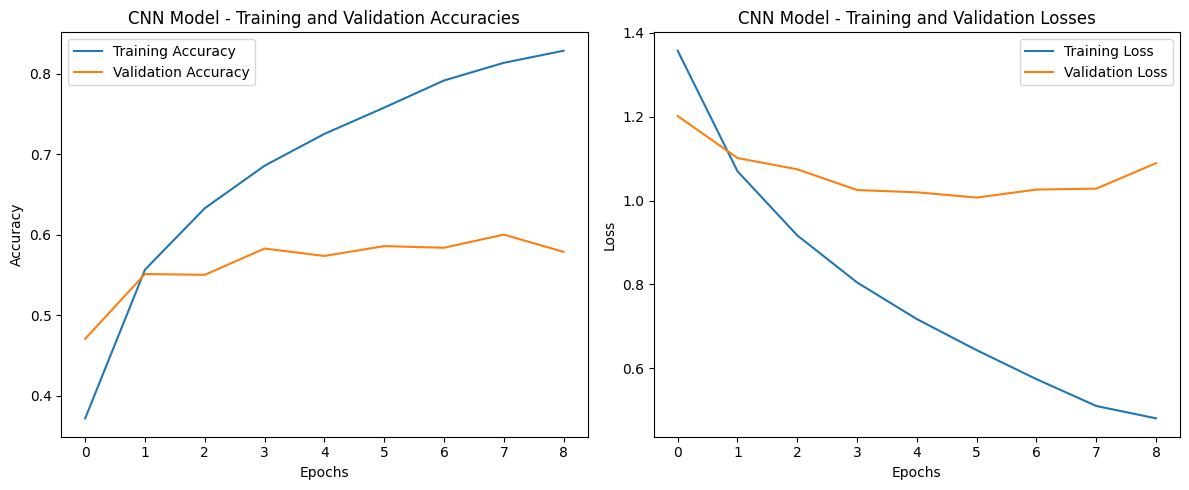

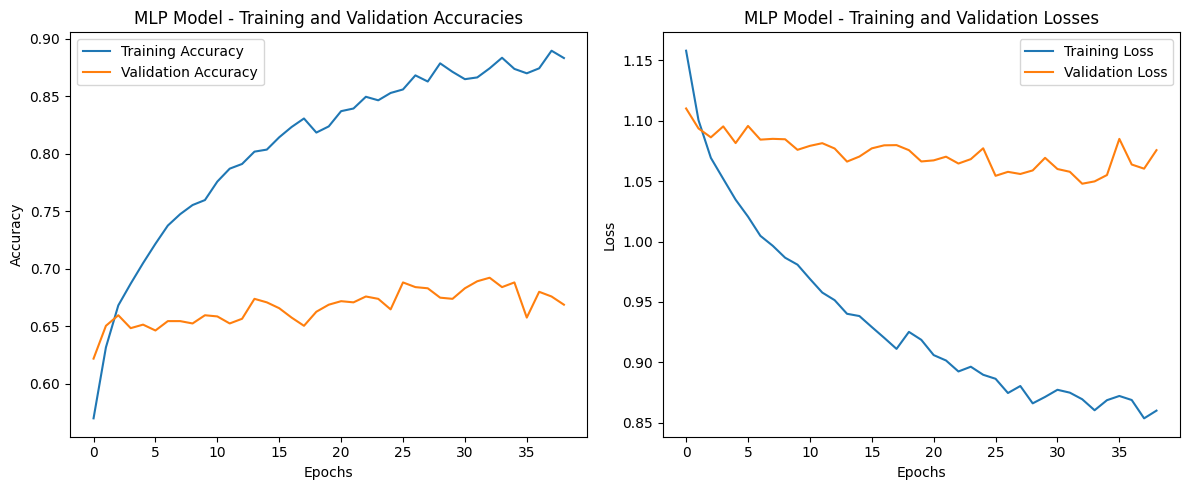

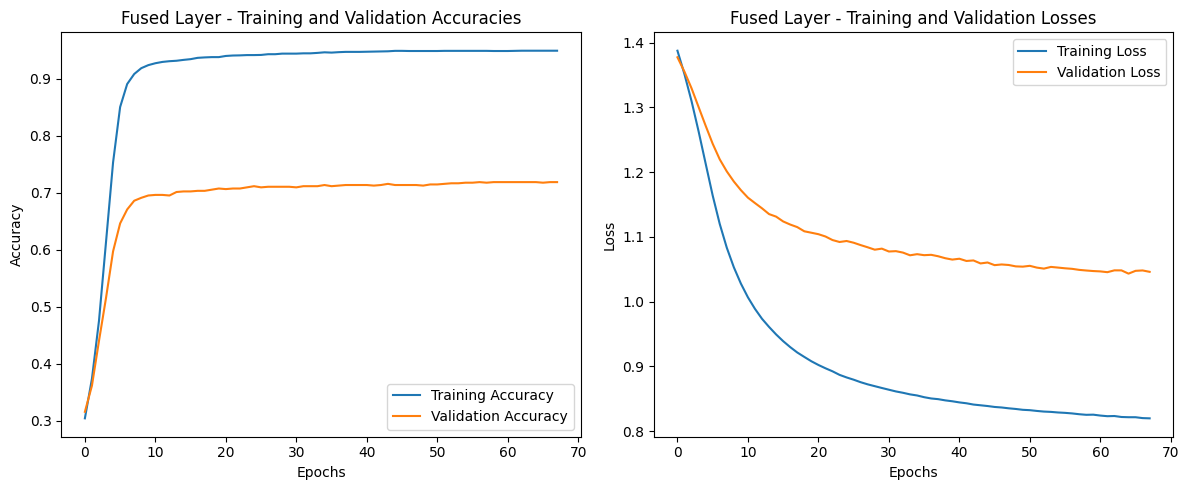

In [13]:

# Plot for CNN model
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(len(training_accuracy_cnn)), training_accuracy_cnn, label='Training Accuracy')
plt.plot(range(len(validation_accuracy_cnn)), validation_accuracy_cnn, label='Validation Accuracy')
plt.title('CNN Model - Training and Validation Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(len(training_losses_cnn)), training_losses_cnn, label='Training Loss')
plt.plot(range(len(validation_losses_cnn)), validation_losses_cnn, label='Validation Loss')
plt.title('CNN Model - Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Plot for MLP model
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(len(training_accuracy_mlp)), training_accuracy_mlp, label='Training Accuracy')
plt.plot(range(len(validation_accuracy_mlp)), validation_accuracy_mlp, label='Validation Accuracy')
plt.title('MLP Model - Training and Validation Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(len(training_losses_mlp)), training_losses_mlp, label='Training Loss')
plt.plot(range(len(validation_losses_mlp)), validation_losses_mlp, label='Validation Loss')
plt.title('MLP Model - Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Plot for Fused Layer
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(len(training_accuracy_fused)), training_accuracy_fused, label='Training Accuracy')
plt.plot(range(len(validation_accuracy_fused)), validation_accuracy_fused, label='Validation Accuracy')
plt.title('Fused Layer - Training and Validation Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(len(training_losses_fused)), training_losses_fused, label='Training Loss')
plt.plot(range(len(validation_losses_fused)), validation_losses_fused, label='Validation Loss')
plt.title('Fused Layer - Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
